# Protein Absorption in Cells

Ryan Jensen

## Introduction

What follows is a proof of concept for using persistent homology to
establish the effectiveness of medication in treating sick cells. Cells
are sick in the sense that they cannot absorb a certain protein. The
medication is suppose to allow the protein to be absorbed. The protein
has been dyed so as to show up in images. The cells are grouped and each
group is given a medication, next the protein is introduced to the cell.
Effective medication have the protein distributed throughout the cell.
Ineffective medication have the protein concentrated along the cell
boundary. The problem is to find a way to compute the effectiveness of
the various medications.

## Imports

Here we import the needed libraries. We are suppressing the messages
from loading the libraries to keep the resulting html document cleaner.
We first check if the package \`install.load\` is installed, if not we
install and load it, if it is installed we simply load it. Next we use
this library to install (if needed) and load the renaming libraries.

In [ ]:
suppressMessages({
  if(!require("install.load")) {
  install.packages("install.load")
  }
})
suppressMessages(install_load("tiff"))      # Using: readTIFF
suppressMessages(install_load("rtiff"))     # Using: autoThreshold
suppressMessages(install_load("RSAGA"))     # Using: grid.to.xyz
suppressMessages(install_load("TDA"))       # Using: ripsDiag, 
suppressMessages(install_load("plotly"))    # Using: plot_ly
suppressMessages(install_load("plot3D"))    # Using: image2D

## Helper Function

This function applies auto-thresholding to its input, which is an image.
If a pixel value is less than the threshold, it replaced by 0. The
algorithm for determining the threshold value is in the package
\`rtiff\`.

In [ ]:
autoTH <- function(x) 
{
  th <- autoThreshold(x, est = .002)
  x[x < th[5]] <- 0
  return(x)
}

## Image Processing Function

This function takes a file path, an optional trim amount, an optional
sample size, and an optional z-distance (the distance between slices in
the cell). It then reads in the stacked image, and trims out the noisy
slices (if a trim amount is supplied). It then applies a thresholding
algorithm to each slice individually (see the helper function above).
Next the image slices are turned into 3D-points, with a 4th dimension
containing the original pixel intensity. A sample is then taken from
this point cloud, and the persistence diagram is computed from this
sample.

The function returns a list containing the original file path of the
image, the raw slices, the trimmed raw slices, the thresholded slices,
the point cloud, the sample point cloud, a 3D plot of the sample point
cloud, and the persistence diagram.

In [ ]:
processImageStack <- function(fp, trmAmnt = NULL, smpSize = NULL, zDist = NULL)
{
  ## Read in the stacked image, then trim out the noise (if told to).
  rawSlices <- readTIFF(fp, indexed = TRUE, native = FALSE, all = TRUE)
  if(is.null(trmAmnt)) trmAmnt <- 1:length(rawSlices)
  rawSlicesTrimmed <- rawSlices[trmAmnt]

  ## Autothreshold each image slice seperatly
  thSlices <- lapply(rawSlicesTrimmed, autoTH)

  ## Convert all image slices (matricies) to point sets, rename z -> intensity
  pntSlices <- lapply( thSlices
                     , function(x) grid.to.xyz(data=x,varname = "intensity"))

  ## Add in z values
  if(is.null(zDist)) zDist <- 3.87595 
  for(i in 1:length(pntSlices))
  {
    pntSlices[[i]]$z = rep((i-1)*zDist)
  }

  ## Concat the lists of points, then switch order so z is before intensity
  pointCloud <- do.call("rbind", pntSlices)
  pointCloud <- pointCloud[, c(1,2,4,3)]


  ## Get a point sample
  if(is.null(smpSize)) smpSize <- 500
  sPointCloud <- pointCloud[ sample( nrow(pointCloud)
                                   , smpSize
                                   , prob = pointCloud$intensity), ]

  ## Generate the plot
  x <- sPointCloud$x
  y <- sPointCloud$y
  z <- sPointCloud$z
  cloudPlot <- {plot_ly(
    x=x, y=y, z=z, 
    type="scatter3d", 
    mode="markers", 
    text=paste("Intensity: ", sPointCloud$intensity),
    marker=list(opacity=.6, color=sPointCloud$intensity)
  ) %>%
  layout(title = fp)
  }

  ## Compute the persistence diagram, only for the spacial coordinates
  sRipsDiag <- {
    ripsDiag(
      sPointCloud[ ,1:3],
      maxdimension = 2,
      maxscale = 40, 
      library = "GUDHI"
    )
  }

  ## Generate our return list
  retList <- {list(
    "filePath"         = fp,
    "rawSlices"        = rawSlices, 
    "rawSlicesTrimmed" = rawSlicesTrimmed,
    "thSlices"         = thSlices,
    "pointCloud"       = pointCloud,
    "sPointCloud"      = sPointCloud,
    "cloudPlot"        = cloudPlot,
    "ripsDiag"         = sRipsDiag
  )}
  return(retList)
}

## Test Image

Now lets run this on a test image.

### Read and Process the Image

In [ ]:
testFP  <- "test.tif"
testT   <- 14:36
testR   <- processImageStack(fp = testFP, trmAmnt = testT, smpSize = 600)

### Results

#### Raw Image Slices

This is a heat map of each slice of the cell in its original state, no
filtering, thresholding, or trimming has been applied at this point.

In [ ]:
image2D(testR$rawSlices,asp = 1, axes=FALSE, colkey = FALSE, xlab="", ylab="")

#### Raw Trimmed Image Slices

Since the first few and last few slices appear to be nothing but noise,
they have been trimmed out, and the results are shown below. The results
from computing the homology are much better when this is done. At this
point the trimming has been done manually based on each image, but it
would be nice to have an automated way to do it.

In [ ]:
image2D(testR$rawSlicesTrimmed,asp = 1, axes=FALSE, colkey = FALSE, xlab="", ylab="")

#### Thresholded Image Slices

Next we show the results after an automatic thresholding function has
been applied to each slice individually. This function comes from an
R-package.

In [ ]:
image2D(testR$thSlices,asp = 1, axes=FALSE, colkey = FALSE, xlab="", ylab="")

#### 3D Point Cloud

Below is an interact 3D point cloud of a random sample taken from the
full point cloud generated from the stacked image. The sample is random,
but points with higher intensity have a higher probability of being
chosen. Hence if there is a high intensity region in the cell, there is
a high probability that the sample will include points from this area.

In [ ]:
testR$cloudPlot

[file:test-3d-point-cloud.html](test-3d-point-cloud.html)

#### The Persistence Diagram

Here is the persistence diagram for the test image. The black dots are
the connected components, the red are the 1-holes, and the blue are the
2-holes. For a cell with high intensity around the boundary, one would
expect a blue point far away from the diagonal. For a cell with
intensity dispersed throughout, one would expect any blue points to be
near the diagonal.

In [ ]:
par(mfrow=c(1,1))
plot(testR$ripsDiag[["diagram"]])

## High Intensity on the Cell Boundary

Here will will look at a cell with high intensity around the cell
boundary. For this example, one would expect the persistence diagram to
have one blue point far away from the diagonal.

### Read and Process the Image

In [ ]:
strongFP <- "Boundary-Strong.tif"
strongT  <- 15:38
strongR  <- processImageStack(fp = strongFP, trmAmnt = strongT)

### Raw Image Slices

In [ ]:
image2D(strongR$rawSlices,asp = 1, axes=FALSE, colkey = FALSE, xlab="", ylab="")

### 3D Point Cloud

In [ ]:
strongR$cloudPlot

[file:high-intensity-boundary.html](high-intensity-boundary.html)

### The Persistence Diagram

In [ ]:
par(mfrow=c(1,1))
plot(strongR$ripsDiag[["diagram"]])

## Medium Intensity on the Cell Boundary

Here will will look at a cell with medium intensity around the cell
boundary. For this example, one would expect the persistence diagram to
have one blue point a moderate distance away from the diagonal.

In [ ]:
mediumFP <- "Boundary-Medium.tif"
mediumT  <- 7:29
mediumR  <- processImageStack(fp = mediumFP, trmAmnt = mediumT)

In [ ]:
image2D(mediumR$rawSlices,asp = 1, axes=FALSE, colkey = FALSE, xlab="", ylab="")

In [ ]:
mediumR$cloudPlot

[file:medium-intensity-boundary.html](medium-intensity-boundary.html)

In [ ]:
par(mfrow=c(1,1))
plot(mediumR$ripsDiag[["diagram"]])

## Low Intensity on the Cell Boundary

Here will will look at a cell with low intensity around the cell
boundary. For this example, one would expect the persistence diagram to
have no blue points except near the diagonal.

In [ ]:
weakFP <- "Boundary-Weak.tif"
weakT  <- 13:29
weakR  <- processImageStack(fp = weakFP, trmAmnt = weakT)

In [ ]:
image2D(weakR$rawSlices,asp = 1, axes=FALSE, colkey = FALSE, xlab="", ylab="")

In [ ]:
weakR$cloudPlot

[file:weak-intensity-boundary.html](weak-intensity-boundary.html)

In [ ]:
par(mfrow=c(1,1))
plot(weakR$ripsDiag[["diagram"]])

## Results Comparison

In [ ]:
par(mfrow=c(3,1))
plot(weakR$ripsDiag[["diagram"]], main="Weak Intensity Boundary")
plot(mediumR$ripsDiag[["diagram"]], main="Medium Intensity Boundary")
plot(strongR$ripsDiag[["diagram"]], main="Strong Intensity Boundary")

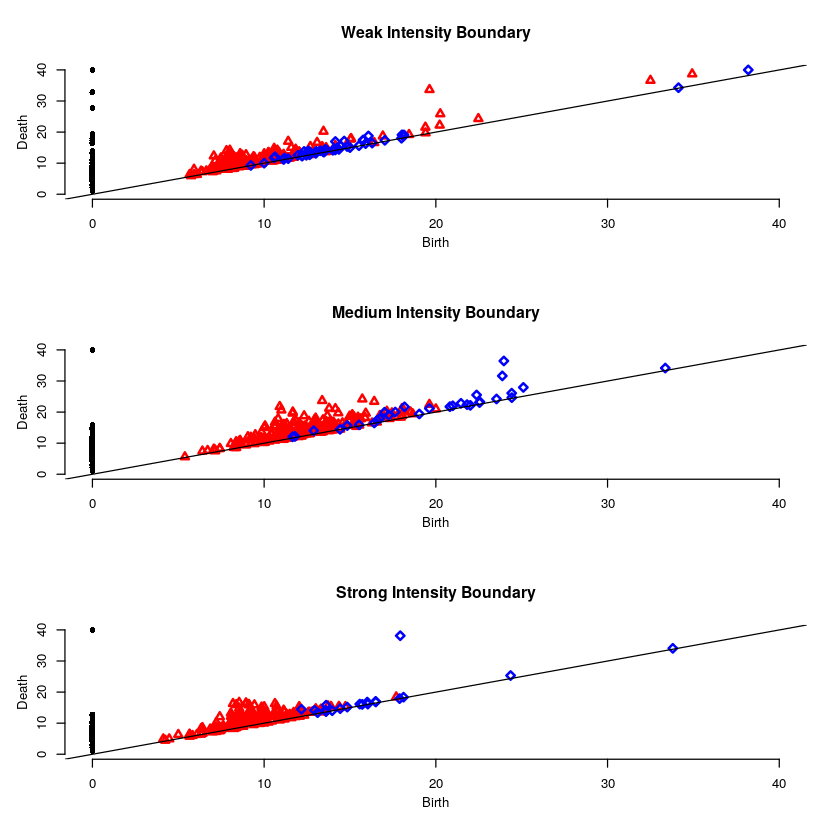

The weak intensity boundary is indicative of the medication working
effectively. The blue dots all begin close to the diagonal in the
persistence diagram indicates that the protein distribution has no voids
and is evenly distributed in the cell.

The strong intensity boundary is indicative of the medication not
working effectively. The blue dot far from the diagonal in the
persistence diagrams indicates that the protein is distributed along the
cell boundary, meaning little protein made it into the cell.